# EXPLORATION 7. 인물사진 만들어보기


## 학습목표

    1. 인물모드 직접 해보기
        - 최소 3장 이상의 인물모드 사진 만들기
        - 사람이 아닌 물체에 대한 사진 만들어보기
    
    2. 사진에서 문제점 찾아보기
        - 인물영역에 포함된 다른 물건이 있는지 확인해보기
        - 그 이외의 다른 문제점이 있는지 확인해보기
    
    3. 문제점에 대한 해결방안 찾아보기

### 인물 사진이 만들어지는 과정

    - 배경이 있는 셀카를 촬영한다.(배경과 사람의 거리가 멀리 있으면 좋다.)
    - 시맨틱 세그멘테이션(Semantic segmentation)으로 피사체(사람)와 배경을 분리한다.
    - 블러링(blurring) 기술로 배경을 흐리게 한다.
    - 피사체를 배경의 원래 위치에 합성한다.

### 첫번째 -  인물사진

In [1]:
# 사용할 라이브러리 불러오기

import os
import urllib  # urllib은 웹에서 데이터를 다운로드할때 사용
import cv2     # cv2는 OpenCV 라이브러리로 이미지를 처리하기 위해서 필요
import numpy as np
from pixellib.semantic import semantic_segmentation   # pixellib은 시맨틱 세그멘테이션을 편하게 사용할 수 있게 도와주는 라이브러리
from matplotlib import pyplot as plt

print('ok')

ok


(1085, 800, 3)


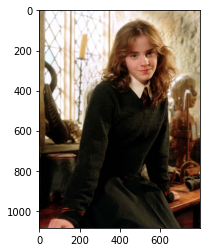

In [38]:
# 사용할 이미지 불러오기

img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/hermi.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)) # cv2는 BGR 형태로 되어있기 때문에 RGB 형태로 바꿔주어야 한다.
plt.show()

In [2]:
# 시맨틱 세그멘테이션 모델 준비하기

# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f92b142e310>)

In [36]:
# 모델 생성하기

model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [39]:
# 모델에 이미지 입력해보기

segvalues, output = model.segmentAsPascalvoc(img_path)

In [6]:
# Pascalvoc 데이터의 라벨 종류 확인하기

LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

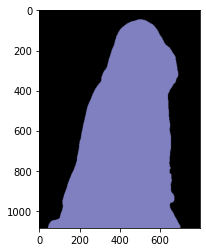

In [7]:
# 입력한 이미지의 출력값 확인하기

plt.imshow(output)
plt.show()

In [8]:
segvalues

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [9]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


    - 이미지가 담고 있는 물체가 뭔지 알 수 있다.
    - 위의 이미지에서는 background와 person 두가지를 담고 있다.

In [10]:
# 이미지의 output에 담겨 있는 색상 확인하기

colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [11]:
# 사람을 나타내는 15번째 색상 찾기

colormap[15]

array([192, 128, 128])

In [12]:
# output 이미지는 BGR 순서로 채널 배치가 되어 있기 때문에 RGB로 변환해줘야 한다.

seg_color = (128,128,192)

(1085, 800)


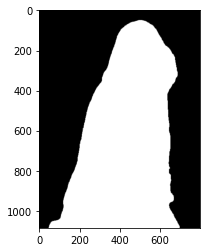

In [13]:
# seg_color로 이루어진 마스크 확인하기
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다

seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

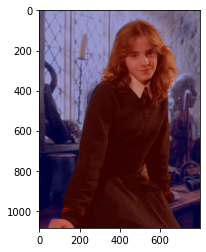

In [14]:
# 원본 이미지에 겹쳐서 확인해보기

img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

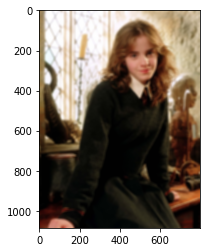

In [15]:
# 배경 블러링(blurring)처리 하기
# (13,13)은 blurring kernel size를 뜻합니다

img_orig_blur = cv2.blur(img_orig, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

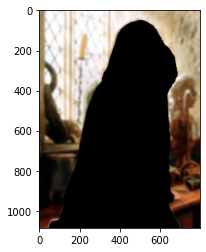

In [16]:
# 흐려진 이미지에서 세그멘테이션 마스크를 사용해서 배경 추출하기

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

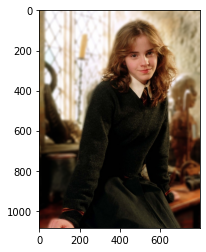

In [17]:
# 배경 영상과 사람 영상 합치기

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 첫번째 인물사진의 문제점 및 해결방법
    - 첫번째 인물사진에서 다른 물체가 인물이 포함된다거나 하는 문제는 발생하지 않았다.
    - 하지만 원본 사진과 비교해볼때 배경이 흐려진건지 확인하기가 조금 애매한 부분이 있었다.
    - 배경이 좀 더 확실하게 흐려졌다는 느낌을 받을 수 있도록 블러링에서 처리를 더 강하게 줘야 할 것 같다.

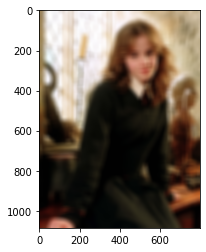

In [18]:
# 배경 블러링 강하게 처리해주기

img_orig_blur_1 = cv2.blur(img_orig, (30,30))  # 원래 기본 수치였던 (13,13)을 (30,30)으로 상승시켜서 적용하였다.
plt.imshow(cv2.cvtColor(img_orig_blur_1, cv2.COLOR_BGR2RGB))
plt.show()

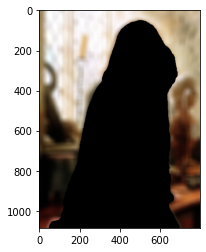

In [19]:
# 흐려진 이미지에서 세그멘테이션 마스크를 사용해서 배경 추출하기

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur_1 = cv2.bitwise_and(img_orig_blur_1, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur_1, cv2.COLOR_BGR2RGB))
plt.show()

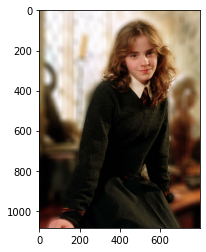

In [20]:
# 배경 영상과 사람 영상 합치기

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur_1)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

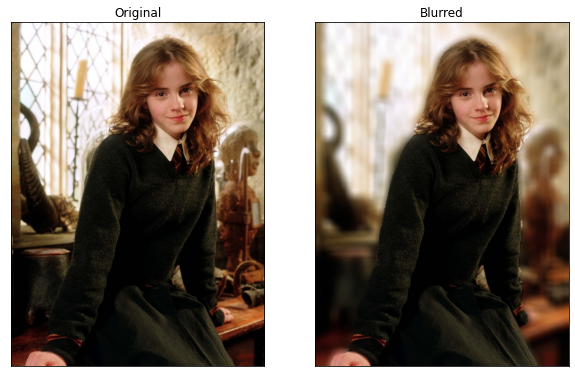

In [21]:
import matplotlib.pyplot as plt

def plotFigures(original_image, blurred_image):
    plt.figure(figsize=(10,10))
    plt.subplot(121)
    plt.imshow(cv2.cvtColor(original_image,cv2.COLOR_BGR2RGB))
    plt.title('Original')
    plt.xticks([]), plt.yticks([])
    
    plt.subplot(122)
    plt.imshow(cv2.cvtColor(blurred_image,cv2.COLOR_BGR2RGB))
    plt.title('Blurred')
    plt.xticks([]), plt.yticks([])
    plt.show()
    
plotFigures(img_orig,img_concat)

### 두번째 - 고양이 사진

(2707, 2030, 3)


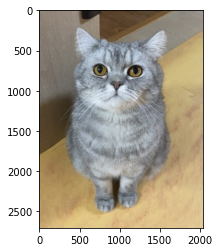

In [27]:
# 사용할 이미지 불러오기

img_path_1 = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat.png'  
img_orig_1 = cv2.imread(img_path_1) 

print(img_orig_1.shape)
plt.imshow(cv2.cvtColor(img_orig_1, cv2.COLOR_BGR2RGB)) # cv2는 BGR 형태로 되어있기 때문에 RGB 형태로 바꿔주어야 한다.
plt.show()

In [8]:
# 모델에 이미지 입력해보기

segvalues, output = model.segmentAsPascalvoc(img_path_1)

In [9]:
# Pascalvoc 데이터의 라벨 종류 확인하기

LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

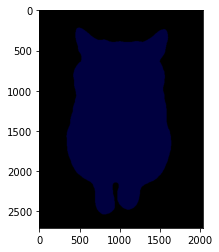

In [10]:
# 입력한 이미지의 출력값 확인하기

plt.imshow(output)
plt.show()

In [11]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
cat


In [12]:
# 이미지의 output에 담겨 있는 색상 확인하기

colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [13]:
# 고양이를 나타내는 8번째 색상 찾기

colormap[8]

array([64,  0,  0])

In [14]:
# output 이미지는 BGR 순서로 채널 배치가 되어 있기 때문에 RGB로 변환해줘야 한다.

seg_color_1 = (0,0,64)

(2707, 2030)


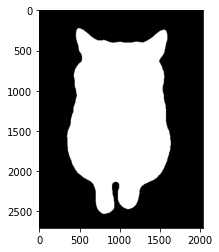

In [15]:
# seg_color로 이루어진 마스크 확인하기
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다

seg_map_1 = np.all(output==seg_color_1, axis=-1)
print(seg_map_1.shape)
plt.imshow(seg_map_1, cmap='gray')
plt.show()

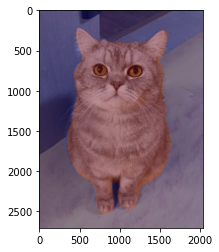

In [16]:
# 원본 이미지에 겹쳐서 확인해보기

img_show_1 = img_orig_1.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask_1 = seg_map_1.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask_1, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show_1 = cv2.addWeighted(img_show_1, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show_1, cv2.COLOR_BGR2RGB))
plt.show()

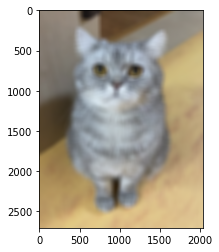

In [17]:
# 배경 블러링(blurring)처리 하기
# (13,13)은 blurring kernel size를 뜻합니다

img_orig_blur_1 = cv2.blur(img_orig_1, (70,70))  
plt.imshow(cv2.cvtColor(img_orig_blur_1, cv2.COLOR_BGR2RGB))
plt.show()

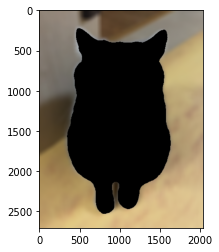

In [18]:
# 흐려진 이미지에서 세그멘테이션 마스크를 사용해서 배경 추출하기

img_mask_color_1 = cv2.cvtColor(img_mask_1, cv2.COLOR_GRAY2BGR)
img_bg_mask_1 = cv2.bitwise_not(img_mask_color_1)
img_bg_blur_1 = cv2.bitwise_and(img_orig_blur_1, img_bg_mask_1)
plt.imshow(cv2.cvtColor(img_bg_blur_1, cv2.COLOR_BGR2RGB))
plt.show()

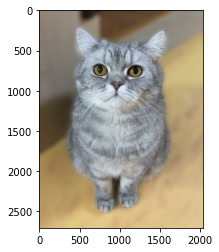

In [19]:
# 배경 영상과 고양이 영상 합치기

img_concat_1 = np.where(img_mask_color_1==255, img_orig_1, img_bg_blur_1)
plt.imshow(cv2.cvtColor(img_concat_1, cv2.COLOR_BGR2RGB))
plt.show()

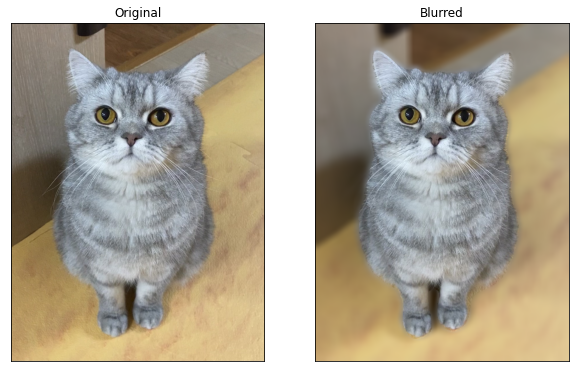

In [20]:
# 원본과 수정한 이미지 비교해보기

import matplotlib.pyplot as plt

def plotFigures(original_image, blurred_image):
    plt.figure(figsize=(10,10))
    plt.subplot(121)
    plt.imshow(cv2.cvtColor(original_image,cv2.COLOR_BGR2RGB))
    plt.title('Original')
    plt.xticks([]), plt.yticks([])
    
    plt.subplot(122)
    plt.imshow(cv2.cvtColor(blurred_image,cv2.COLOR_BGR2RGB))
    plt.title('Blurred')
    plt.xticks([]), plt.yticks([])
    plt.show()
    
plotFigures(img_orig_1,img_concat_1)

### 세번째 - 배경 전환 사진

(600, 800, 3)


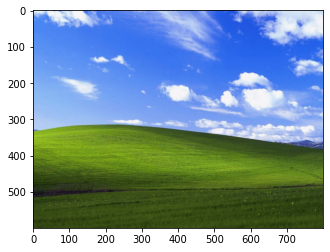

In [31]:
# 사용할 이미지 불러오기

img_path_2 = os.getenv('HOME')+'/aiffel/human_segmentation/images/background.png'  
bg_orig_2 = cv2.imread(img_path_2) 

print(bg_orig_2.shape)
plt.imshow(cv2.cvtColor(bg_orig_2, cv2.COLOR_BGR2RGB)) # cv2는 BGR 형태로 되어있기 때문에 RGB 형태로 바꿔주어야 한다.
plt.show()

In [32]:
# 배경 사이즈 resized

target_size = (img_orig_1.shape[1], img_orig_1.shape[0])
bg_resized = cv2.resize(bg_orig_2, target_size)
print(bg_resized.shape)

(2707, 2030, 3)


Text(0.5, 1.0, 'background Cat')

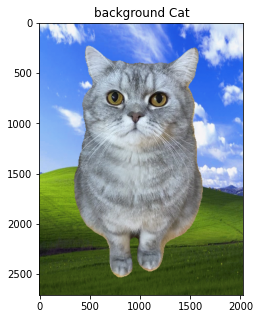

In [35]:
# 배경과 고양이 합치기

img_concat = np.where(img_mask_color_1==255, img_orig_1, bg_resized)

plt.figure(figsize=(5,5))

plt.subplot(111)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.title('background Cat')

### 배경 전환 사진의 문제점

  - 배경을 전환시켜서 고양이를 합성시키는데는 성공했다.
  - 하지만 사진에서 보면 알 수 있듯이 고양이의 외곽선이 원본 사진의 바닥 조명색이 합쳐져서 고양이 원래의 색이 온전하게 나오지 못하였다.
  - 고양이 외곽선에 따로 색을 보정해주거나 고양이 색으로 변환시켜주는 작업이 필요할 것 같다.
  - 그리고 고양이 사진 크기와 배경의 크기가 언밸런스하다.
  - 배경에 고양이가 적절한 크기로 합성될 수 있도록 사이즈 조절을 다시 해야 할 것 같다.

## 회고

  - 사진에 블러링을 하는 과정은 생각보다 어렵지 않았다.
  - 블러링이 잘 되지 않았다고 생각될 때는 블러링의 강도를 조절해서 더 진하게 하면 내가 생각한 수준의 아웃포커싱 사진을 얻을 수 있었다.
  - 또 내가 사용한 사진이 생각보다 이미지가 잘 떠져서 다른 사물들이 같이 합성되는 등의 문제는 따로 발생하지 않았다.
  - 가장 어려웠던 점은 배경을 사진에 합성하는 과정이었다.
  - 블러링은 원본 사진을 가지고 작업한다면 배경을 합성하는 것은 두개의 사진을 가지고 작업하는 과정이어서 더 까다로웠던것 같다.
  - 특히 사진 size가 통일되지 않아서 그 과정을 찾아내는데 시간이 많이 사용되었다.
  - 그리고 배경사진과 고양이 사진의 size문제는 머리로는 어떻게 해야겠다는 생각은 할 수 있겠는데 그것을 코드로 만들어가는 과정이 생각이 나지 않아서 따로 시도해보지 못했다.
  - 다른 사람들이 배경 전환을 한 블로그나 포스팅이 있다면 먼저 읽어보고 가이드를 짜야할 것 같다.